In [41]:
import numpy as np
import sys

In [42]:
np.random.seed(1)

In [43]:
class Net(object):
    """Simple multi-layer perceptron classifier.
    
    Parameters
    ----------
    n_hidden : int
        Number of hidden units.
    l2 : float
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int
        Number of passes over the training set.
    eta : float
        Learning rate.
    shuffle : bool
        Shuffles training data every epoch
        if True to prevent circles.
    minibatch_size : int
        Number of training samples per minibatch.
    seed : int
        Random seed for initializing weights and shuffling.
    
    Attributes
    -----------
    eval_ : dict
        Dictionary collecting the cost, training accuracy,
        and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=30, l2=0., epochs=100, 
                 eta=0.001, shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
        
        Parameters
        ----------
        y : array, shape = [n_samples]
            Target values.
        
        Returns
        -----------
        onehot : array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
    
    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        """Propogate through the network"""
        z_h = X @ self.w_h + self.b_h # net input of hidden layer
        a_h = self._sigmoid(z_h) # activation of hidden layer
        z_out = a_h @ self.w_out + self.b_out # net input for out layer
        a_out = self._sigmoid(z_out) # activation for out layer
        
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """Compute cost function
        
        Parameters
        ----------
        y_enc : array
            one-hot encoded class labels.
        output : array
            Activation of the output layer (forward propagation)
        
        Returns
        ---------
        cost : float
            Regularized cost
        """
        L2_term = (self.l2 * (np.sum(self.w_h**2.) + np.sum(self.w_out**2.)))
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost
    
    def predict(self, X):
        """Predict class labels
        
        Parameters
        ----------
        X : array, shape = [n_samples, n_features]
            Input later with original features
        
        Returns
        -------
        y_pred : array, shape = [n_samples]
            Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """Learn weights from training data
        
        Parameters
        ----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training
        
        Returns
        -------
        self
        """
        n_output = np.unique(y_train).shape[0] # yields no of class labels
        n_features = X_train.shape[1]
        
        #########################
        # WEIGHT INITIALIZATION #
        #########################
        
        # weights for layer.input -> layer.hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden)) # Use Gaussian random noise for init.
        
        # weights for layer.hidden -> layer.output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        y_train_enc = self._onehot(y_train, n_output)
        
        # iterate over training epochs
        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle: self.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                ###################
                # Backpropagation #
                ###################
                
                # n_samples, n_classlabels
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # n_samples, n_hidden
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden] -> [n_samples, n_hidden]
                sigma_h = sigma_out @ self.w_out.T
                
                grad_w_h = X_train[batch_idx].T @ sigma_h
                grad_b_h = np.sum(sigma_h, axis=0)
                
                grad_w_out = a_h.T @ sigma_out
                grad_b_out = np.sum(sigma_out, axis=0)
                
                # now, update weights by SGD
                delta_w_h = grad_w_h + self.l2*self.w_h
                delta_b_h = grad_b_h
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = grad_w_out + self.l2*self.w_out
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            ##############
            # Evaluation #
            ##############
            
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            print('\r%0*d/%d | Cost : %.2f | Train/Valid Acc. : %.2f%%/%.2f%%' % 
                  (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            
        return self

In [44]:
import tensorflow as tf

In [45]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Text(0.5, 1.0, '5')

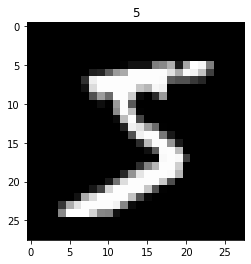

In [47]:
plt.imshow(x_train[0], cmap='gray')
plt.title(y_train[0])

In [48]:
net = Net(epochs=50, minibatch_size=5)

In [49]:
x_valid = x_train[55000:]
y_valid = y_train[55000:]

In [50]:
x_train = x_train[:55000]
y_train = y_train[:55000]

In [51]:
x_train = x_train.reshape(55000, -1)
x_valid = x_valid.reshape(5000, -1)

In [52]:
x_train.shape, x_valid.shape

((55000, 784), (5000, 784))

In [85]:
avg = x_train.mean()
std = x_train.std()
print("mean={}, std={}".format(avg, std)) #### Most IMPORTANT part is that we have mu=0 and rho=1

mean=2.387502687820255e-17, std=0.9999999999999993


In [54]:
def normalize(x, avg):
    return (x - avg)/x.std()

In [55]:
x_train = normalize(x_train, avg)

In [56]:
x_valid = normalize(x_valid, avg)

In [57]:
net.fit(x_train, y_train, x_valid, y_valid)

01/50 | Cost : 69101.46 | Train/Valid Acc. : 81.29%/85.50%
02/50 | Cost : 56535.11 | Train/Valid Acc. : 84.72%/88.48%
03/50 | Cost : 51599.30 | Train/Valid Acc. : 85.42%/89.14%
04/50 | Cost : 48726.35 | Train/Valid Acc. : 86.30%/89.46%
05/50 | Cost : 47165.35 | Train/Valid Acc. : 86.46%/89.88%
06/50 | Cost : 46067.10 | Train/Valid Acc. : 86.76%/89.86%
07/50 | Cost : 45368.43 | Train/Valid Acc. : 86.92%/90.38%
08/50 | Cost : 44496.06 | Train/Valid Acc. : 87.28%/90.38%
09/50 | Cost : 43826.59 | Train/Valid Acc. : 87.49%/90.46%
10/50 | Cost : 43112.26 | Train/Valid Acc. : 87.62%/90.56%
11/50 | Cost : 42700.30 | Train/Valid Acc. : 87.70%/90.88%
12/50 | Cost : 42212.46 | Train/Valid Acc. : 87.78%/90.94%
13/50 | Cost : 41810.86 | Train/Valid Acc. : 87.90%/91.08%
14/50 | Cost : 41494.13 | Train/Valid Acc. : 88.07%/91.04%
15/50 | Cost : 41302.82 | Train/Valid Acc. : 88.13%/90.98%
16/50 | Cost : 40953.35 | Train/Valid Acc. : 88.19%/91.06%
17/50 | Cost : 40768.41 | Train/Valid Acc. : 88.25%/90.9

In [58]:
net.predict(x_test[0].reshape(1,784)) 

array([7])

In [59]:
def show_and_predict(xb):
    """Get a random batch of 9 samples and plot them in 3x3 grid"""
    fig = plt.figure(figsize=(10,10))
#    plt.subplots_adjust(hspace=1)
    for i in range(9):
        n = np.random.randint(xb.shape[0])
        yhat = net.predict(normalize(xb[n], avg).reshape(1,784))
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(xb[n], cmap='gray')
        ax.set_title(
            'Pred:%s \nAct: %s' % (int(yhat), y_test[n]), 
            fontdict={'fontsize': 11})
        ax.set_axis_off()

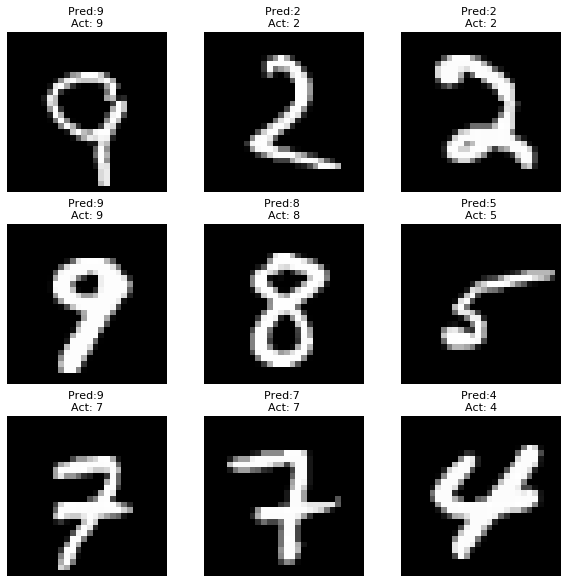

In [60]:
show_and_predict(x_test)

In [61]:
net.eval_['cost']
net.eval_['train_acc']

[0.8129090909090909,
 0.8472,
 0.8542181818181818,
 0.8629636363636364,
 0.8646,
 0.8675636363636363,
 0.8692,
 0.8727636363636364,
 0.874890909090909,
 0.8761818181818182,
 0.8770181818181818,
 0.8778181818181818,
 0.8790181818181818,
 0.8806909090909091,
 0.8812909090909091,
 0.8819272727272728,
 0.8824545454545455,
 0.8833636363636364,
 0.8839454545454546,
 0.8828727272727273,
 0.8837272727272727,
 0.8845090909090909,
 0.8849818181818182,
 0.8838,
 0.8841272727272728,
 0.8849454545454546,
 0.8837636363636364,
 0.8852,
 0.8849636363636364,
 0.8862363636363636,
 0.8856363636363637,
 0.886109090909091,
 0.8863454545454545,
 0.8864909090909091,
 0.8864727272727273,
 0.8862363636363636,
 0.8864545454545455,
 0.8861636363636364,
 0.887,
 0.8872363636363636,
 0.8866909090909091,
 0.8874909090909091,
 0.8868363636363636,
 0.887109090909091,
 0.8881636363636364,
 0.8882,
 0.8887272727272727,
 0.8885454545454545,
 0.8886727272727273,
 0.8887272727272727]

In [62]:
plt.imshow??

In [63]:
%whos

Variable           Type        Data/Info
----------------------------------------
Image              module      <module 'PIL.Image' from <...>e-packages/PIL/Image.py'>
Net                type        <class '__main__.Net'>
NeuralNetMLP       type        <class '__main__.NeuralNetMLP'>
avg                float64     33.332771405380335
net                Net         <__main__.Net object at 0x7fb18cc2f810>
normalize          function    <function normalize at 0x7fb18cc2e7a0>
np                 module      <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
plt                module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
show_and_predict   function    <function show_and_predict at 0x7fb18cc2e560>
sys                module      <module 'sys' (built-in)>
tf                 module      <module 'tensorflow' from<...>/tensorflow/__init__.py'>
x_test             ndarray     10000x28x28: 7840000 elems, type `uint8`, 7840000 bytes (7.476806640625 Mb)
x_train            nd

In [64]:
#inc_index = []
#for i in range(x_test.shape[0]):
#    x_hat = net.predict(normalize(x_test[i], avg).reshape(1,784))
#    if x_hat != y_test[i]: inc_index.append(i)

In [68]:
#def pred_err(xb, yb):
#    """Get a batch of 9 select samples with errors and plot them in 3x3 grid"""
#    fig = plt.figure(figsize=(10,10))
#    plt.subplots_adjust(hspace=1)
#    for i in range(9):
#        yhat = net.predict(normalize(xb[i], avg).reshape(1,784))
#        ax = fig.add_subplot(3,3,i+1)
#        ax.imshow(xb[i], cmap='gray')
#        ax.set_title(
#            'Pred:%s \nAct: %s' % (int(yhat), yb[i]), 
#            fontdict={'fontsize': 11})
#        ax.set_axis_off()

In [66]:
#b1 = inc_index[:10]

In [69]:
#pred_err(x_test[b1], y_test[b1])